# 선형 회귀모형

관심있는 반응 변수와 설명변수의 함수적인 관계를 추론하는 경우 사용할 수 있는 가장 단순하고 기본적인 모형은 선형 회귀모형(linear regression model)이다. 선형 회귀모형은  설명변수의 변화에 따른 반응변수의 변화를 선형식으로 나타낸 매우 단순한 모형이다. 이 절에서는 선형 회귀모형을 추정하는 방법을 살펴보기로 한다.  

In [1]:
# 한글 폰트가 깨질 때 사용 - 런타임 메뉴에서 다시 시작 및 모두 실행 선택. (출처: https://teddylee777.github.io/colab/colab-korean)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

'sudo'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


'sudo'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


'rm'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from matplotlib import rc
%matplotlib inline

plt.rc('font', family='NanumBarunGothic') # clolab 에서 한글 사용 
plt.rcParams['axes.unicode_minus'] = False 
plt.rcParams["figure.figsize"] = (10,7)   # 그림 크기 조정

## 아버지와 아들의 키: 평균들의 관계

먼저 앞 절에서 살펴본 Francis Galton의  아버지와 아들의 키에 대한 데이터를 먼저 데이터프레임으로 만들자.

In [4]:
url1 = "https://ilovedata.github.io/teaching/bigdata2/data/father-and-son.csv"
father_son_df = pd.read_csv(url1, sep=',', encoding = 'utf-8-sig')
father_son_df.fheight =  father_son_df.fheight*2.54
father_son_df.sheight =  father_son_df.sheight*2.54

아버지와 아들의 키는 아래 주어진 산점도에서 나타나는 것처럼 아버지의 키기 증가하면 아들의 키가 증가하는 경향을 보인다. 

<AxesSubplot:xlabel='fheight', ylabel='sheight'>

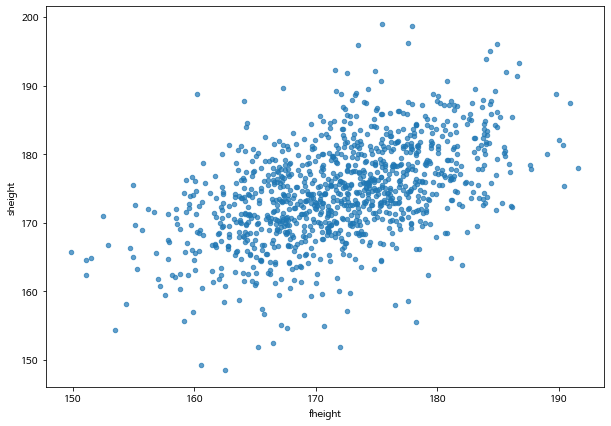

In [5]:
father_son_df.plot.scatter(x='fheight', y='sheight', alpha=0.7)


여기서 경향(trend)라는 말에 주의하자. 경향을 보인다는 것은 아버지의 키를 알고 있다면 아들의 키를 정확하게 예측할 수는 없지만 아버지의 키가 증가하면 평균적으로 아들의 키도 증가한다는 것이다.

이렇게 "어떤 경향을 보인다" 라는 말을 통계적으로 어떻게 구체적으로 나타낼 수 있을까?  

아버지의 키를  몇 개의 그룹을 나누어서 생각해 보자. 이제 자료를 다음과 같이 나누어 보자.

- 그룹 1: $140 <\text{아버지의 키} \le 160$
- 그룹 2: $160 < \text{아버지의 키} \le 170$
- 그룹 3: $170 < \text{아버지의 키} \le 180$
- 그룹 4: $180 < \text{아버지의 키} \le 200$

위와 같이 전체 데이터를 아버지의 키에 따라서 4개의 그룹으로 나누고 아들의 키의 분포가 어떻게 변하는지 살펴보자.

아래에서 사용한 `pandas` 라이브러리의 `pd.cut` 함수는 첫 번째 인자로 주어진 숫자의 벡터나 시리즈를 두 번째 인자로 주어진 리스트나 벡터의 숫자를 이용하여 구간을 나누어 주는 기능을 한다. 두 번쨰 인자로 주어진 `[140, 160, 170, 180]` 은 각 구간의 끝 값을 지정해 주면 선택명령문 `include_lowest=False` 는 구간을 설정할 때 작은 구간값을 포함하지 말라는 의미이다. 즉, 아래 명령문은 다음과 같은 4개의 구간으로 아버지의 키를 그룹화 해준다.

```
(140, 160], (160, 170], (170, 180] (180, 200] 
``` 


In [6]:
father_son_df['group1']= pd.cut(father_son_df.fheight, [140,160,170,180,200], include_lowest=False)
father_son_df

,fheight,sheight,group1
0,165.223215,151.836806,"(160, 170]"
1,160.657388,160.563662,"(160, 170]"
2,164.986513,160.889747,"(160, 170]"
3,167.011350,159.492645,"(160, 170]"
4,155.288564,163.274070,"(140, 160]"
...,...,...,...
1073,170.171897,179.710893,"(170, 180]"
1074,181.182797,173.400060,"(180, 200]"
1075,182.329176,176.036961,"(180, 200]"
1076,179.675460,176.027055,"(170, 180]"


In [7]:
father_son_df.group1

0       (160, 170]
1       (160, 170]
2       (160, 170]
3       (160, 170]
4       (140, 160]
           ...    
1073    (170, 180]
1074    (180, 200]
1075    (180, 200]
1076    (170, 180]
1077    (170, 180]
Name: group1, Length: 1078, dtype: category
Categories (4, interval[int64, right]): [(140, 160] < (160, 170] < (170, 180] < (180, 200]]

위에서 아버지의 키의 크기에 따라 나눈 4개의 그룹에 대하여 아버지의 키 평균과 아들의 키 평균을 구해보자. 

다음에 나타난 것처럼 그룹렬로 보면 아버지의 키 평균의 증가하면 아들의 키 평균도 증가한다.  
4개의 그룹별 평균이 마치 하나의 직선위에 있는 것 처럼 보인다.

전체 데이터의 산점도에서 나타나는 불확실한 경향은 자료를 여러 개의 그룹으로 나누어 두 변수의 그룹별 평균으로 요약하여 보면 평균의 관계는 좀 더 명확하게 나타난다.


In [8]:
group_summary_1 = father_son_df.groupby(by='group1').mean().reset_index(drop=True)
group_summary_1 

,fheight,sheight
0,157.033422,167.000530
1,165.980611,171.199651
2,174.580022,175.916772
3,183.188398,180.367088


<AxesSubplot:xlabel='fheight', ylabel='sheight'>

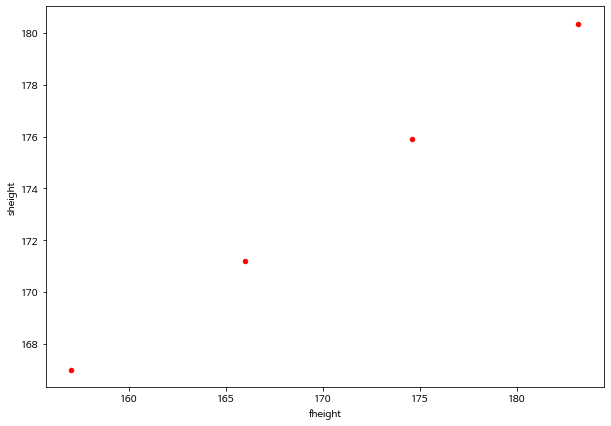

In [9]:
group_summary_1.plot.scatter(x='fheight', y='sheight', c='red')


다음으로 그룹의 간격을 조금 더 잘게 나누어서 각 그룹의 평균이 어떻게 변하는지 살펴보자.


아래 코드에서 함수 `pd.cut` 의 두 번째 인자로 하나의 정수 `bins=10` 로 주면 주어진 숫자열을  등간격인 `k=10`의 구간으로 나누어 준다. 

In [10]:
father_son_df['group2']= pd.cut(father_son_df.fheight, 10, include_lowest=False)
father_son_df


,fheight,sheight,group1,group2
0,165.223215,151.836806,"(160, 170]","(162.397, 166.569]"
1,160.657388,160.563662,"(160, 170]","(158.225, 162.397]"
2,164.986513,160.889747,"(160, 170]","(162.397, 166.569]"
3,167.011350,159.492645,"(160, 170]","(166.569, 170.741]"
4,155.288564,163.274070,"(140, 160]","(154.053, 158.225]"
...,...,...,...,...
1073,170.171897,179.710893,"(170, 180]","(166.569, 170.741]"
1074,181.182797,173.400060,"(180, 200]","(179.086, 183.258]"
1075,182.329176,176.036961,"(180, 200]","(179.086, 183.258]"
1076,179.675460,176.027055,"(170, 180]","(179.086, 183.258]"


In [11]:
father_son_df.group2

0       (162.397, 166.569]
1       (158.225, 162.397]
2       (162.397, 166.569]
3       (166.569, 170.741]
4       (154.053, 158.225]
               ...        
1073    (166.569, 170.741]
1074    (179.086, 183.258]
1075    (179.086, 183.258]
1076    (179.086, 183.258]
1077    (174.913, 179.086]
Name: group2, Length: 1078, dtype: category
Categories (10, interval[float64, right]): [(149.839, 154.053] < (154.053, 158.225] < (158.225, 162.397] < (162.397, 166.569] ... (174.913, 179.086] < (179.086, 183.258] < (183.258, 187.43] < (187.43, 191.602]]

In [12]:
group_summary_2 = father_son_df.groupby(by='group2').mean().reset_index(drop=True)
group_summary_2 

,fheight,sheight
0,151.778186,164.266746
1,156.395947,166.528948
2,160.678486,169.238409
3,164.750386,170.586666
4,168.611132,172.252867
5,172.840256,175.327199
6,176.902658,176.889192
7,180.899270,179.205668
8,184.504045,181.519479
9,189.708045,181.022422


<AxesSubplot:xlabel='fheight', ylabel='sheight'>

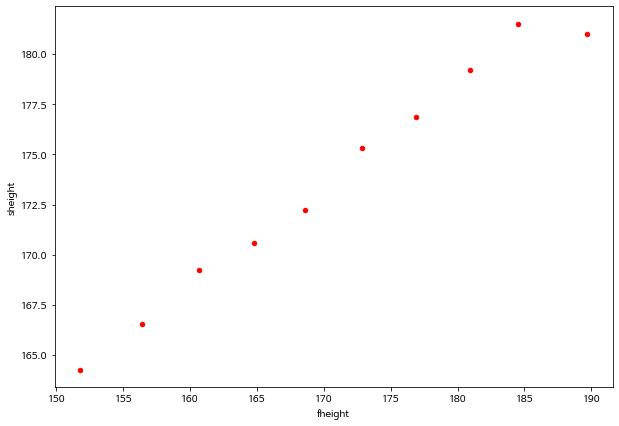

In [13]:
group_summary_2.plot.scatter(x='fheight', y='sheight', c='red')


위에서 주어진 10개의 구간에 대한 아버지와 아들의 평균 키에 대한 관계는  하나의 직선과 같은 관계를 보인다. 

각 구간에 대한 아버지와 아들 키의 평균은 아주 단순한 일차식으로 다음과 같이 나타낼 수 있다.

$$ \text{mean of son's heights} \approx \beta_0 + \beta_1 (\text{mean of father's height}) $$

이제 위에서 구한 구간의 평균들을 전체 자료의 산점도와 함깨 표시해 보자.  

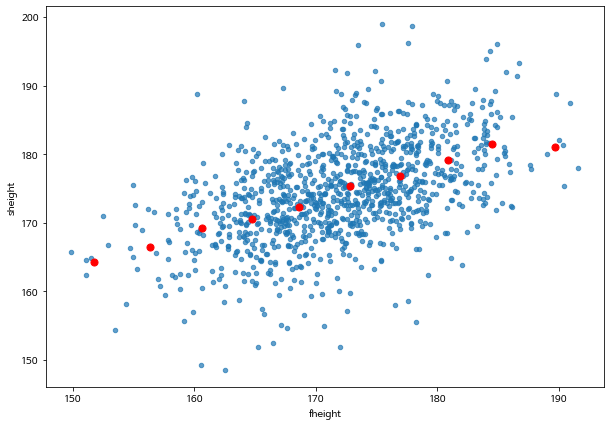

In [14]:
father_son_df.plot.scatter(x='fheight', y='sheight', alpha=0.7)
plt.scatter(group_summary_2.fheight, group_summary_2.sheight, c='red', s=50)

위의 그림에서 나타난 빨간 점들은 주어진 아버지의 키 구간에서 아들의 키들의 평균값을 표시한 것이다. 아버지의 키의 평균과 아들 키의 평균이 직선과 같은 관계를 가지는 것을 알 수 있다.

**선형 회귀모형(linear regression model)은 반응변수 $y$의 평균이 설명변수 $x$의 값에 따라서 직선으로 변하는 것을 나타내는 모형** 이다.


$$ E(y|x) = \beta_0 + \beta_1 x $$

위의 식에서 $E(y|x)$는 설명변수 $x$의 값이 주어진 경우 반응변수 $y$의 평균(Expectation, Mean)을 의미한다. 


## 최소제곱법

### 최소제곱법의 기준

이제 위에서 주어진 선형 회귀모형에서 직선의 기울기 $\beta_1$ 과 절편 $\beta_0$를 데이터를 이용하여 결정하는 기준과 방법에 대하여 알아보자.

최소제곱법(least square method)은 설명변수의 값 $x_i$ 에 대하여 실제 관측한 반응변수의 값 $y_i$와 선형 회귀직선 위에 있는 값 $\beta_0 + \beta_1 x_i$ 값이 **가장 가깝게 나타나도록** 기울기 $\beta_1$ 과 절편 $\beta_0$을 결정하는 방법이다.

두 개의 주어진 수가 가장 가깝다는 것을 정하려면  두 수의 거리(distance)를 정의해야 한다. 
최소제곱법에서는 거리를 두 수의 차이를 제곱한 값으로 사용한다.

정리하면 반응변수 $y$와 설명변수 $x$에 대한 $n$ 개의 자료가 다음과 같이 주어진 경우

$$ (x_1, y_1), ~ (x_2, y_2), \dots , (x_n, y_n)$$

최소제곱법은 다음과 같은 조건을 만족하는 기울기 $\beta_1$ 과 절편 $\beta_0$의 값을 구하는 방법이다.

$$ \min_{\beta_0, \beta_1} \frac{1}{n} \sum_{i=1}^n (y_i - [\beta_0 + \beta_1 x_i])^2  $$

위의 식에서 설명변수의 값 $x_i$ 에 대하여 관측값 $y_i$ 과 직선 위에 있는 값의 차이를 오차(error)라고 부른다.

$$ \text{error}_i = y_i - (\beta_0 + \beta_1 x_i) = y_i - E(y_i | x_i) $$

따라서 최소제곱법은 실제 자료와 직선식으로 표현된 평균값의 차이들의 제곱합를 최소화하는 기울기와 절편을 찾는 방법이다. 

### 평균제곱오차 


이제 절편 $\beta_0 = \beta_{0}^*$ 와 기울기 $\beta_1 = \beta_1^*$ 로 그 값이 주어진 경우 실제 자료와 직선식으로 표현된 평균값의 차이들의 제곱합을 다음과 같이 나타내면 이 값을 평균제곱오차(Mean Squared Error; mse) 라고 부른다.

$$ mse(\beta_0^*, \beta_1^*) = \frac{1}{n} \sum_{i=1}^n (y_i - [\beta_0^* + \beta_1^* x_i])^2  = \frac{1}{n} \sum_{i=1}^n  \text{error}_i^2 $$

이제 절편과 기울기가 주어진 경우 주어진 직선의 오차를 그림으로 나타내고 평균제곱오차를 계산해 주는 함수 `least_square_error`를 다음과 같이 정의하여 만들어 보자.

In [15]:
def least_squares_error( df, x_name, y_name, intercept, slope, percent_poiint_errors):
  """
  목적
    주어진 절편과 기울기를 이용하여 회귀직선을 그리고 최소제곱오차를 계산하는 함수
  함수의 인자
    df: 데이터프레임
    x_name: 데이터프레임에 있는 설명변수의 열이름
    y_name: 데이터프레임에 있는 반응변수의 열이름
    intercept: 회귀직선의 절편
    slope: 회귀직선의 기울기
    percent_poiint_errors : 오차(빨간 선)를 표시할 데이터의 비율(0과 1사이의 값)

  출력값: 
    mse: 평균제곱오차
  """
  df0 = df[[x_name, y_name]]
  df0.plot.scatter(x=x_name, y= y_name, alpha=0.7)
  xlims = np.array([np.min(df0[x_name])*0.95, np.max(df0[x_name])*1.05])
  plt.plot(xlims, slope * xlims + intercept, lw=2)
  
  n = df0.shape[0]
  show_error = np.random.binomial(1, percent_poiint_errors, size=n )
  
  mse = 0
  for i, (x, y) in enumerate(np.array(df0)):
    if  show_error[i] == 1 :
      plt.plot([x, x], [y, slope * x + intercept], color='r', lw=2)
    mse = mse + (y- (slope * x + intercept))**2
  return(mse/n)

아래 그림은 다음과 같이 절편이 $\beta_0=20.0$, 기울기가 $\beta_1 = 0.8$ 가 주어진 경우 아버의 키($x$)와 아들의 키($y$0)의 관계를  선형 회귀직선을 나타낸 것이다.

$$ E(y |x)  = 20.0 + (0.8)x $$

몇 개의 데이터(1%)에서 오차의 크기를 빨간 선으로 나타내었다.

$$ \text{error}_i = y_i -[20.0 + (0.8)x_i] $$

이 경우 평균제곱오차의 값은 151.042 이다.

$$ mse(20.0, 0.8) = \frac{1}{n} \sum_{i=1}^n \text{error}_i^2 = 328.397 $$


328.39745463232754

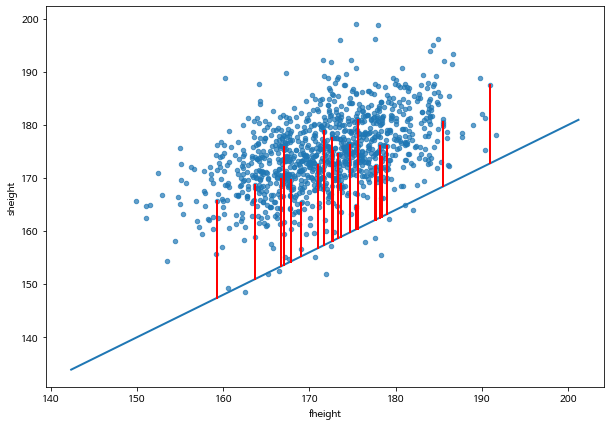

In [16]:
mse_1 = least_squares_error(father_son_df, 'fheight', 'sheight', 20.0, 0.8, 0.02)
mse_1

이제 아래 그림은   절편이 $\beta_0=25.0$, 기울기가 $\beta_1 = 0.9$ 으로 주어진 경우 아버지의 키($x$)와 아들의 키($y$)의 관계를  선형 회귀직선을 나타낸 것이다.

$$ \text{error}_i = y_i - [25.0 + (0.9)x_i] $$

이 경우 평균제곱오차의 값은 73.29 이다.

$$ mse(25.0, 0.9) =  \frac{1}{n} \sum_{i=1}^n \text{error}_i^2 = 73.29 $$


73.29044331530777

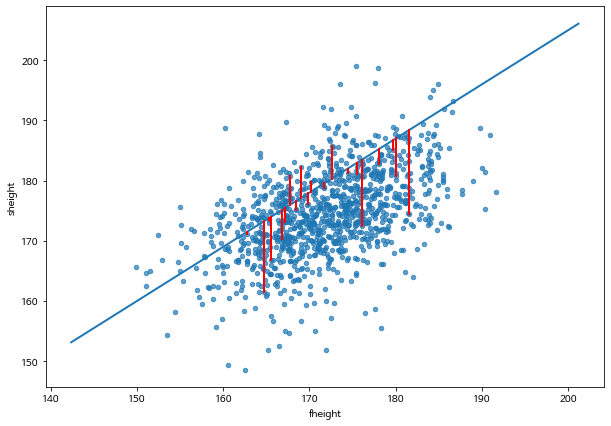

In [17]:
mse_2 = least_squares_error(father_son_df, 'fheight', 'sheight', 25.0, 0.9, 0.02)
mse_2

### 최소제곱법의 해

이렇게 절편과 기울기의 값이 변하면 평균제곱오차의 크기도 변한다. 그러면 평균제곱오차를 최소화하는 최적의 절편과 기울기는 어떻게 구할까?

앞에서 언급한 것과 같이 설명변수($x_i$)와 반응변수($y_i$)의 데이터가 $n$개 주어진 경우, 평균제곱오차를 최소화하는 최소제곱법의 해(solution) $\hat \beta_0$와 $\hat \beta_1$ 은 다음과 같이 주어진다. 


$$ \hat \beta_1 = r \frac{SD_y}{SD_x},  \quad \quad \hat \beta_0 = \bar y - \hat \beta_1 \bar x $$

위의 식에서 사용되는 통계량은 다음과 같다.

- $r$ : 설명변수($x_i$)와 반응변수($y_i$)의 상관계수
- $\bar x$ : 설명변수($x_i$)의 평균
- $\bar y$ : 반응변수($y_i$)의 평균
- $SD_x$ : 설명변수($x_i$)의 표준편차
- $SD_y$ : 반응변수($y_i$)의 평균


본 강의에서는 평균제곱오차를 최소화하는 최적의 절편과 기울기를 유도하는 자세한 방법은 배우지 않을 것이다. 

이제  최소제곱법의 해(solution) $\hat \beta_0$와 $\hat \beta_1$ 을 구하는 함수 `least_square_fit`을 정의해 보자.

In [18]:
def least_squares_fit( df, x_name, y_name):
  """
  목적
    주어진 자료를 이용하여 최소제곱 절편과 기울기 계산하는 함수
  함수의 인자
    df: 데이터프레임
    x_name: 데이터프레임에 있는 설명변수의 열이름
    y_name: 데이터프레임에 있는 반응변수의 열이름
  출력값: 
    b0: 절편
    b1: 기울기
  """
  x = np.array(df[x_name])
  y = np.array(df[y_name])
  x_bar = np.mean(x)
  y_bar = np.mean(y)
  SD_x = np.std(x)
  SD_y = np.std(y)
  n=len(x)

  x_st = (x - x_bar)/SD_x
  y_st = (y - y_bar)/SD_y

  r = np.sum( x_st * y_st )/n
  
  b1 = r*SD_y/SD_x
  b0 = y_bar - b1*x_bar

  return(b0,b1)

이제 위에서 구한 최소제곱법으로 구한 절편과 기울기의 추정량 $\hat \beta_0$과 $\hat \beta_1$을 구해보자.

$$ \min_{\beta_0, \beta_1} \frac{1}{n} \sum_{i=1}^n (y_i - [\beta_0 + \beta_1 x_i])^2 =  \frac{1}{n} \sum_{i=1}^n (y_i - [\hat \beta_0 + \hat \beta_1 x_i])^2  $$


In [19]:
(beta0, beta1) = least_squares_fit(father_son_df, 'fheight', 'sheight')
(beta0, beta1)

(86.07197505935795, 0.5140930386233076)

기울기의 추정량은 $\hat \beta_1= 0.514$로 상관계수의 값과 매우 유사하다. 아버지와 아들의 키에 대한 표준편차가 거의 동일하기 때문에 이 경우 기울기의 추정량은 상관계수와 기울기는 거의 같다.

최소제곱 추정량(least square estimator) $\hat \beta_0$과 $\hat \beta_1$ 에서의 평균제곱오차는 다음의 코드에서 함수  `least_squares_error` 로 구할 수 있다. 

절편과 기울기의 최소제곱 추정량 $\hat \beta_0$과 $\hat \beta_1$ 으로 부터 얻은 평균제곱오차의 값 38.23은 모든 경우에 대한 최소값이다. 즉, 절편과 기울기가  $\hat \beta_0$과 $\hat \beta_1$ 와 다른 값을 가지는 경우 평균제곱오차는 38.23보다 크다.

38.23082448512252

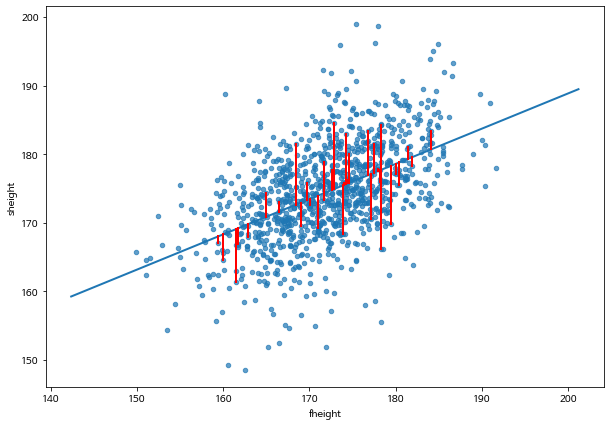

In [20]:
mse_best = least_squares_error(father_son_df, 'fheight', 'sheight', beta0, beta1, 0.03)
mse_best

아버지의 키($x$)와 아들의 키($y$)의 관계를 선형 회귀모형으로 나타낼 때 추정된 회귀직선은 다음과 같다. 

$$ E(y|x) = 86.07 + (0.51) x $$

위의 식은 아버지의 키가 1cm 증가하면 아들 키의 평균이 0.51 cm 증가한다는 의미이다. 

위에서 추정된 식은 아버지의 키가 주어진 경우 아들의 키에 대한 예측에 사용할 수 있다. 예를 들어 아버지의 키가 185.0 cm 인 경우 **아들의 평균적인 키** 는 다음과 같이 예측할 수 있다.

$$ E(y | x = 185.0) = 86.07 + (0.51) (185.0) =  181.2 $$


In [21]:
beta0 + beta1*185.0

181.17918720466986

위의 추정된 회귀직선을 사용할 때 유의할 점은 주어진 아들의 키에 대한 예측값은 **아들의 평균적인 키에 대한 예측값** 이라는 것이다. 위에서 구한 회귀직선은 주어진 설명변수 $x$ 에 대한 반응변수 $y$의 평균을 나타내는 직선이며 실제 관측한 반응변수의 값들은 직선을 중심으로 퍼져있다.




## 선형 회귀모형의 평가 

위에서 아버지와 아들의 키의 관계를 선형 회귀모형으로 나타내는 경우, 실제 관측값들은 추정된 회귀직선 주위에 퍼져서 나타난다. 추정된 회귀직선으로 부터 반응변수의 관측값들이 퍼진 정도가 작아지면 회귀모형이 반응변수와 설명변수의 관계를 더욱 잘 설명하는것으로 판단할 수 있다.

다음 두 개의 데이터와 각각 추정된 회귀직선을 비교해 보자.


In [22]:
np.random.seed(111121)

n=20

sigma1 = 5.0
x = np.random.normal(0,1,n)
y = 1.0 + 1.5 * x +  np.random.normal(0,sigma1,n)
df_reg_1 = pd.DataFrame({'x':x, 'y':y})
df_reg_1["case"] = "Large errors"

sigma2 = 1.0
x = np.random.normal(0,1,n)
y = 1.0 + 1.5 * x +  np.random.normal(0,sigma2,n)
df_reg_2 = pd.DataFrame({'x':x, 'y':y})
df_reg_2["case"] = "Small errors"

df_reg = pd.concat([df_reg_1,df_reg_2 ], axis=0)

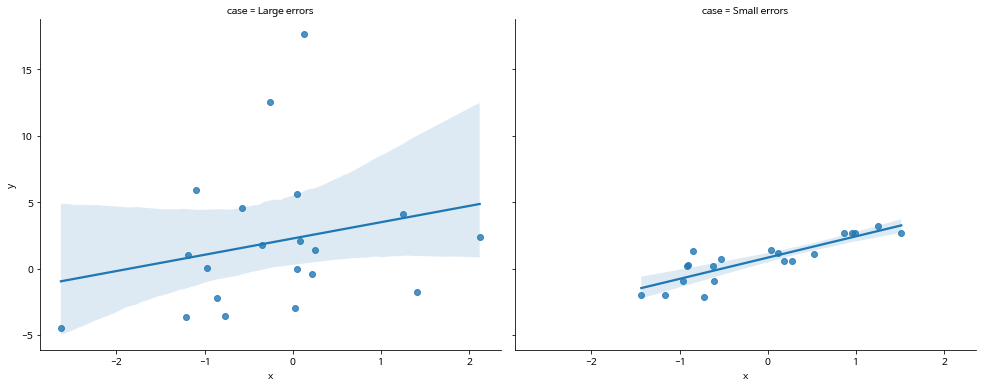

In [23]:
g = sns.FacetGrid(df_reg,  col="case", margin_titles=True, height=5.5, aspect=1.25)
g.map(sns.regplot, "x", "y")

첫번째 그림과 두 번째 그림을 비교하면 두 번째 데이터에서 적합한 선형 회귀모형이 첫 번째 데이터의 모형보다 오차(error)가 더 작은 것을 알 수 있다.

$$ \text{error}_i = y_i - (\hat \beta_0 + \hat \beta_1 x_i)  $$

오차가 작을수록 회귀모형이 두 변수의 관계를 설명하는 능력이 더 뛰어나다는 것을 의미한다. 따라서 평균오차제곱합 $mse$가 작을 수록 관계를 더 잘 설명하는 모형이다.

$$  mse = \frac{1}{n}  \sum_{i=1}^n \text{error}_i^2 $$

하지만 평균오차제곱합 $mse$는 자료의 단위에 따라서 변화되는 측도이므로 이를 단위에 따라서 변하지 않게 표준화시켜야지 서로 다른 회귀직선의 설명력과 서로 비교할 수 있다.

선형 회귀모형이 **설명변수와 반응변수의 관계를 설명하는 능력에 대하여 평가하는 측도를 결정계수(coefficient of determination; $R^2$)** 라고 하며  평균제곱오차 $mse$ 와 반응변수의 분산 $SD_y^2$ 을 이용하여 다음과 같은 정의한다.

$$ R^2 = 1- \frac{mse}{SD^2_y} $$

결정계수는 0과 1의 값을 가지면 보통 백분율로 표시한다. 결정계수의 값이 클수록 선형 회귀모형이 설명변수와 반응변수의 관계를 설명하는 능력이 커진다.

아래에서 두 자료에서의 결정계수를 비교하면 첫 번째 자료에 대한 선형 회귀모형의 결정계수는 5.5% 이고 두 번째 자료에 대해서는 74.6 %이다. 따라서 두 번째 자료에 대한 회귀모형의 설명력이 더 크다고 평가할 수 있다.

26.971200022915433

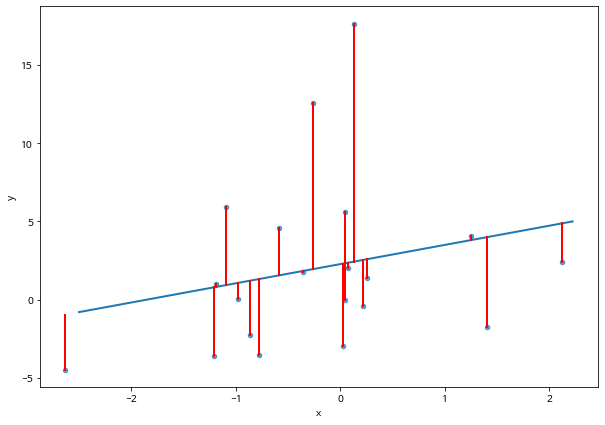

In [24]:
(reg_1_beta0, reg_1_beta1) = least_squares_fit(df_reg_1, 'x', 'y')
mse_reg_1 = least_squares_error(df_reg_1, 'x', 'y', reg_1_beta0, reg_1_beta1, 1)
mse_reg_1

0.6519429797067264

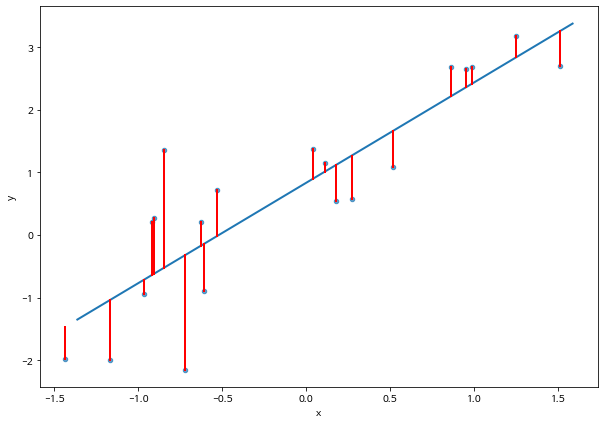

In [25]:
(reg_2_beta0, reg_2_beta1) = least_squares_fit(df_reg_2, 'x', 'y')
mse_reg_2 = least_squares_error(df_reg_2, 'x', 'y', reg_2_beta0, reg_2_beta1, 1)
mse_reg_2

In [26]:
#결정 계수의 계산
R2_reg_1 = 1 - mse_reg_1/(np.std(df_reg_1.y)**2)
R2_reg_2 = 1 - mse_reg_2/(np.std(df_reg_2.y)**2)
R2_reg_1, R2_reg_2

(0.05540917626273012, 0.7466063931874196)

아버지와 아들에 키에 대한 자료에서 선형 회귀모형의 설명력은 다음과 같다.

In [27]:
1 - mse_best/(np.std(father_son_df.sheight)**2)

0.25134010224913694

## `SKlearn` 패키지

`SKlearn` 패키지는 기계학습에서 이용되는 다양한 모형들을 모아놓은 패키지이다.

다음은 아버지와 아들의 키 자료에 대하여 `SKlearn` 패키지의 `linear_model` 라이브러리를 이용하여 위에서 배운 선형 회귀모형을 적합하고 여러 가지 통계량을 얻을 수 있는 코드이다.

`SKlearn` 패키지의 `linear_model` 라이브러리를 이용하기 위해서는 데이터프레임으로 저장된 자료를 `numpy` 의 행렬 형식으로 바꾸어야 한다. 또한 설명변수가 1개인 경우 $(-1,1)$ 사이의 값으으로 변화시켜주어야 한다.

In [28]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [29]:
# 설명변수 지정 - 설변변수가 1개이므로 (-1,1) 사이의 값으로 변환
x = np.array(father_son_df['fheight']).reshape(-1, 1)
# 반응변수 지정
y = np.array(father_son_df['sheight'])
# 선형 회귀모형의 지정
reg_model = linear_model.LinearRegression()
# 선형회귀모형을 최소제고법으로 적합
reg_model.fit(x,y)
# 회귀직선 계산
y_pred = reg_model.predict(x)


In [30]:

# 절편과 기울기의 추정량
print("절편(intercept): ", reg_model.intercept_)
print("기울기(slope): ", reg_model.coef_)
# 평균제곱오차
print("평균제곱오차, mse: %.2f" % mean_squared_error(y, y_pred))
# 결정계수
print("결정계수 R^2: %.2f" % r2_score(y, y_pred))


절편(intercept):  86.07197505935797
기울기(slope):  [0.51409304]
평균제곱오차, mse: 38.23
결정계수 R^2: 0.25
